In [1]:
!pip install -q imbalanced-learn xgboost

In [3]:
# Data manipulation
import pandas as pd
import numpy as np
from collections import Counter

# Enable experimental features (must come before using them)
from sklearn.experimental import enable_halving_search_cv  # noqa

# Scikit-learn preprocessing, model selection & evaluation
from sklearn.model_selection import train_test_split, HalvingRandomSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Classifier
from sklearn.ensemble import RandomForestClassifier

# Imbalanced data handling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# XGBoost
from xgboost import XGBClassifier


In [4]:
df = pd.read_csv("Fraud.csv")

In [5]:
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

In [6]:
df.drop(columns=['nameOrig', 'nameDest'], inplace=True)

In [7]:
df['deltaOrig'] = df['newbalanceOrig'] - df['oldbalanceOrg']
df['deltaDest'] = df['newbalanceDest'] - df['oldbalanceDest']
df.drop(columns=['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest'], inplace=True)

In [8]:
X = df.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = df['isFraud']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


In [31]:
numeric_features = ['amount', 'deltaOrig', 'deltaDest']
categorical_features = ['type']


In [32]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)


In [33]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [34]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

In [35]:
pipeline = Pipeline([
    ('classifier', RandomForestClassifier(random_state=42))
])

In [36]:
param_distributions = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, None],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
}

In [38]:
import shutil
shutil.rmtree('/tmp', ignore_errors=True)


In [39]:
import os

os.environ['JOBLIB_TEMP_FOLDER'] = '/content/tmp_joblib'
os.makedirs('/content/tmp_joblib', exist_ok=True)

In [40]:
# Kill variables not needed
%reset_selective -f search pipeline

# Or force garbage collection
import gc
gc.collect()

0

In [41]:
search = HalvingRandomSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    factor=2,
    resource='n_samples',
    max_resources='auto',
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    n_jobs=1,
    random_state=42,
    verbose=1
)

In [42]:
search.fit(X_train_resampled, y_train_resampled)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 19
min_resources_: 12
max_resources_: 3747960
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 16
n_resources: 12
Fitting 3 folds for each of 16 candidates, totalling 48 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 16 is smaller than n_iter=312330. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


----------
iter: 1
n_candidates: 8
n_resources: 24
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 2
n_candidates: 4
n_resources: 48
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 3
n_candidates: 2
n_resources: 96
Fitting 3 folds for each of 2 candidates, totalling 6 fits
----------
iter: 4
n_candidates: 1
n_resources: 192
Fitting 3 folds for each of 1 candidates, totalling 3 fits


HalvingRandomSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                      estimator=Pipeline(steps=[('classifier',
                                                 RandomForestClassifier(random_state=42))]),
                      factor=2, n_jobs=1,
                      param_distributions={'classifier__max_depth': [10, None],
                                           'classifier__min_samples_leaf': [1,
                                                                            2],
                                           'classifier__min_samples_split': [2,
                                                                             5],
                                           'classifier__n_estimators': [100,
                                                                        200]},
                      random_state=42, verbose=1)

In [45]:
print("Best parameters found:")
print(search.best_params_)

Best parameters found:
{'classifier__n_estimators': 100, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': None}


In [46]:
best_model = search.best_estimator_

In [50]:
y_prob = best_model.predict_proba(X_test_processed)[:, 1]
threshold = 0.87
y_pred_thresh = (y_prob > threshold).astype(int)
print(classification_report(y_test, y_pred_thresh))

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99    468495
         1.0       0.05      0.85      0.09       430

    accuracy                           0.98    468925
   macro avg       0.52      0.92      0.54    468925
weighted avg       1.00      0.98      0.99    468925



In [52]:
from sklearn.metrics import roc_auc_score, average_precision_score

print("ROC AUC:", roc_auc_score(y_test, y_prob))
print("Average Precision:", average_precision_score(y_test, y_prob))


ROC AUC: 0.9832417933029988
Average Precision: 0.13754640834003076


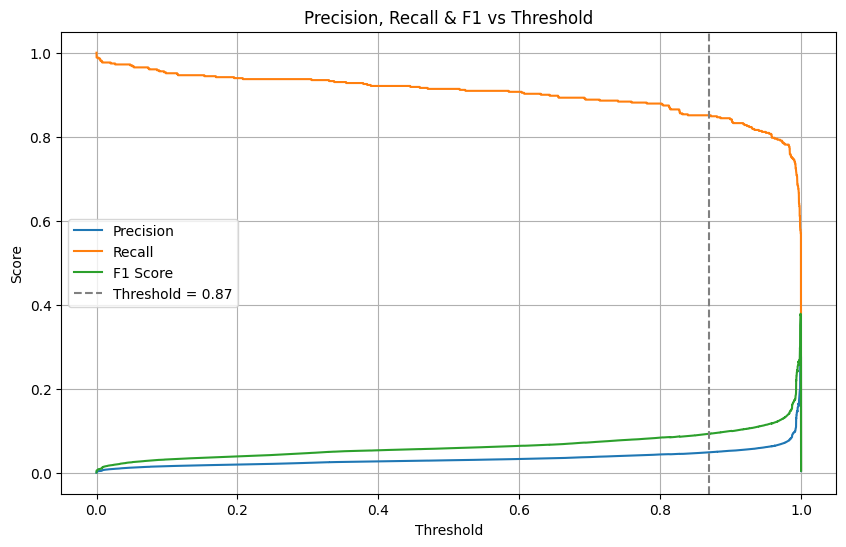

In [53]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
f1 = 2 * (precision * recall) / (precision + recall + 1e-6)

plt.figure(figsize=(10,6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.plot(thresholds, f1[:-1], label='F1 Score')
plt.axvline(0.87, color='gray', linestyle='--', label='Threshold = 0.87')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall & F1 vs Threshold')
plt.legend()
plt.grid()
plt.show()
